In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

c:\Users\grzegorzzakrzewski\AppData\Local\miniconda3\envs\SMAC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,log_cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,1.558145,0.95,1.0,0.0,0.0,0.2,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,-3.506558,0.15,0.0,1.0,1.0,0.4,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,1.316408,0.20,0.0,1.0,2.0,0.9,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.425268,0.60,1.0,1.0,2.0,0.7,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,4.436160,0.90,1.0,1.0,3.0,0.3,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,5.339123,0.45,0.0,0.0,0.0,0.2,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,5.703816,0.20,1.0,0.0,3.0,0.6,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,1.169381,0.95,1.0,1.0,3.0,0.9,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,2.847232,0.65,0.0,0.0,1.0,0.5,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
from utils import get_n_splits

In [4]:
train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

df_train = df.loc[train_idx]
# X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_train = np.zeros(X_train.shape[0], dtype=[('is_censored', bool), ('cost', float)])
# # y_train['is_censored'] = (df_train["cost"] >= 1).to_numpy()
# y_train['is_censored'] = (df_train["cost"] == 300).to_numpy()
# # y_train['cost'] = df_train["cost"].clip(upper=1)
# # y_train['cost'] = np.log(df_train["cost"].clip(upper=1) + 1)
# y_train['cost'] = df_train["cost"]

# df_test = df.loc[test_idx]
# X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_test = np.zeros(X_test.shape[0], dtype=[('is_censored', bool), ('cost', float)])
# # y_test['is_censored'] = (df_test["cost"] >= 1).to_numpy()
# y_train['is_censored'] = (df_train["cost"] == 300).to_numpy()
# # y_test['cost'] = df_test["cost"].clip(upper=1)
# # y_test['cost'] = np.log(df_test["cost"].clip(upper=1) + 1)
# y_train['cost'] = df_train["cost"]

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [90]:
train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

rng = np.random.default_rng(0)
df_train = df.loc[train_idx]

unique_solvers = df_train["solver_id"].unique()
solver_permutation = rng.permutation(unique_solvers)
solver_order = {solver_id: order for order, solver_id in enumerate(solver_permutation)}
df_train["solver_order"] = df_train["solver_id"].map(solver_order)
df_train = df_train.sort_values(["solver_order", "instance_id"])
cum_min_cost = df_train.groupby("instance_id")["cost"].cummin()
df_train = df_train.drop(columns=["solver_order"])
df_train


# cut_off = df_train["instance_id"].map(cut_off_per_instance).to_numpy() # add some noise to the cut-off
# cut_off *= rng.normal(1, 0.5, size=cut_off.shape) # add some noise to the cut-off
# cut_off = np.clip(cut_off, 0.01, None) # clip to 0

# cut_off_per_instance = df_train.groupby("instance_id")["cost"].min()
# cut_off = df_train["instance_id"].map(cut_off_per_instance).to_numpy()
# cut_off += rng.lognormal(mean=0, sigma=0.5, size=cut_off.shape)

# X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_train = np.zeros(X_train.shape[0], dtype=[('is_censored', bool), ('cost', float)])
# y_train['is_censored'] = (df_train["cost"] >= cut_off).to_numpy()
# y_train['cost'] = df_train["cost"].clip(upper=cut_off)

# df_test = df.loc[test_idx]
# X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# cut_off = np.exp(rng.uniform(0, 6, size=df_test.shape[0]))
# y_test = np.zeros(X_test.shape[0], dtype=[('is_censored', bool), ('cost', float)])
# y_test['is_censored'] = (df_test["cost"] >= cut_off).to_numpy()
# y_test['cost'] = df_test["cost"].clip(upper=cut_off)

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

,solver_id,instance_id,generator,cost,log_cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
3515,727187247634425562,TSP/TRAIN/cluster_netgen/003.tsp,cluster_netgen,300.00,5.703816,0.9,1.0,0.0,1.0,0.7,...,0.264924,0.956299,0.000066,0.000481,0.009527,0.012297,0.062248,0.009262,0.061767,0.753178
11515,727187247634425562,TSP/TRAIN/cluster_netgen/011.tsp,cluster_netgen,300.00,5.703816,0.9,1.0,0.0,1.0,0.7,...,0.444117,1.562059,0.000100,0.000617,0.010474,0.013162,0.091301,0.010252,0.090685,0.778914
46515,727187247634425562,TSP/TRAIN/expansion/006.tsp,expansion,300.00,5.703816,0.9,1.0,0.0,1.0,0.7,...,0.525224,1.604922,0.000223,0.001534,0.012113,0.018348,0.210005,0.021815,0.208471,1.188956
53515,727187247634425562,TSP/TRAIN/expansion/013.tsp,expansion,300.00,5.703816,0.9,1.0,0.0,1.0,0.7,...,0.466543,1.357204,0.000597,0.004108,0.025035,0.031055,0.421396,0.038430,0.417288,1.237467
55515,727187247634425562,TSP/TRAIN/expansion/015.tsp,expansion,300.00,5.703816,0.9,1.0,0.0,1.0,0.7,...,0.287505,1.191989,0.000381,0.000747,0.016415,0.024465,0.170680,0.026328,0.169934,1.076178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59644,959715947635945075,TSP/TRAIN/expansion/019.tsp,expansion,0.66,-0.400478,0.0,0.0,0.0,3.0,0.3,...,0.285572,1.025388,0.000226,0.000342,0.016116,0.022769,0.285915,0.027422,0.285572,1.204374
63644,959715947635945075,TSP/TRAIN/explosion/003.tsp,explosion,5.31,1.671473,0.0,0.0,0.0,3.0,0.3,...,0.187880,0.792831,0.000141,0.002517,0.016915,0.020604,0.158672,0.016302,0.156155,0.791191
70644,959715947635945075,TSP/TRAIN/explosion/010.tsp,explosion,1.39,0.336472,0.0,0.0,0.0,3.0,0.3,...,0.138878,0.624813,0.000140,0.000268,0.018417,0.022604,0.139146,0.016743,0.138878,0.740711
74644,959715947635945075,TSP/TRAIN/explosion/014.tsp,explosion,0.40,-0.891598,0.0,0.0,0.0,3.0,0.3,...,0.151691,0.618975,0.000228,0.002139,0.021946,0.026997,0.153831,0.019129,0.151691,0.708547


In [ ]:
train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

rng = np.random.default_rng(0)
df_train = df.loc[train_idx]

solver_avg_costs = df_train.groupby("solver_id")["cost"].mean().reset_index()
log_cost = np.log1p(solver_avg_costs["cost"].to_numpy())
inv_log_costs = np.max(log_cost) - log_cost + 1
probs = inv_log_costs / np.sum(inv_log_costs)

unique_solvers = solver_avg_costs["solver_id"].to_numpy()
num_solvers = len(unique_solvers)
solver_permutation = np.zeros(num_solvers, dtype=object)
remaining_indices = np.arange(num_solvers)
for i in range(num_solvers):
    curr_probs = probs[remaining_indices] / np.sum(probs[remaining_indices])
    chosen_idx = rng.choice(len(remaining_indices), p=curr_probs)
    solver_idx = remaining_indices[chosen_idx]
    solver_permutation[i] = unique_solvers[solver_idx]
    remaining_indices = np.delete(remaining_indices, chosen_idx)

solver_order = {solver_id: order for order, solver_id in enumerate(solver_permutation)}
df_train["solver_order"] = df_train["solver_id"].map(solver_order)
df_train = df_train.sort_values(["solver_order", "instance_id"])
cum_min_cost = df_train.groupby("instance_id")["cost"].cummin()
df_train = df_train.drop(columns=["solver_order"])

##
# X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
# y_train = np.zeros(X_train.shape[0], dtype=[('is_censored', bool), ('cost', float)])
# y_train['is_censored'] = (df_train["cost"] >= cum_min_cost).to_numpy()
# y_train['cost'] = df_train["cost"].clip(upper=cum_min_cost)

# pd.Series(y_train["is_censored"]).value_counts()

True    1500
dtype: int64

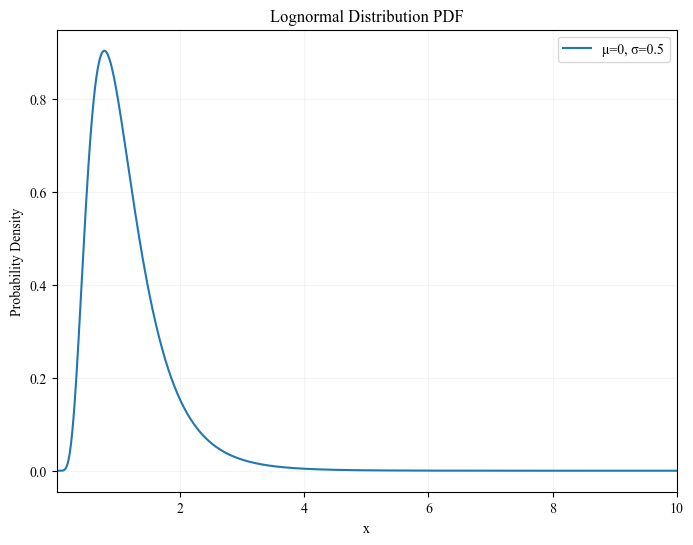

In [118]:
from scipy.stats import lognorm

x = np.linspace(0.01, 10, 1000)
mu = 0
sigma = 0.5

plt.figure(figsize=(8, 6))
plt.plot(x, lognorm.pdf(x, sigma, scale=np.exp(mu)), label=f'μ={mu}, σ={sigma}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Lognormal Distribution PDF')
plt.legend()
plt.grid(True)
plt.show()


In [279]:
from sksurv.ensemble import RandomSurvivalForest

model = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=0,
)
model.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=0)

In [280]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

model2 = CoxPHSurvivalAnalysis(alpha=1.0, ties='efron')
model2.fit(X_train, y_train)

CoxPHSurvivalAnalysis(alpha=1.0, ties='efron')

In [281]:
y_pred = pd.Series(model.predict(X_test))
y_pred2 = pd.Series(model2.predict(X_test))

In [282]:
sf_pred = model.predict_survival_function(X_test, return_array=True)
sf_pred2 = model2.predict_survival_function(X_test, return_array=True)

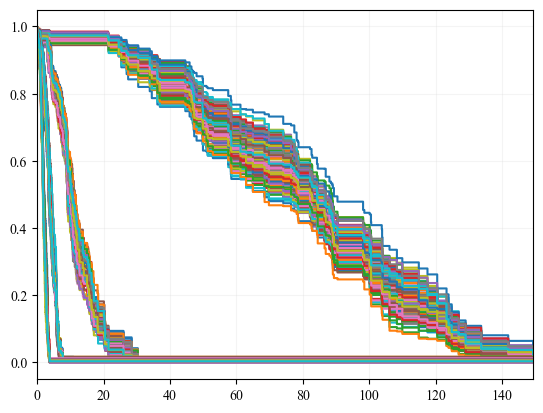

In [284]:
for i, s in enumerate(sf_pred[:500]):
    plt.step(model.unique_times_, s, where="post", label=str(i))

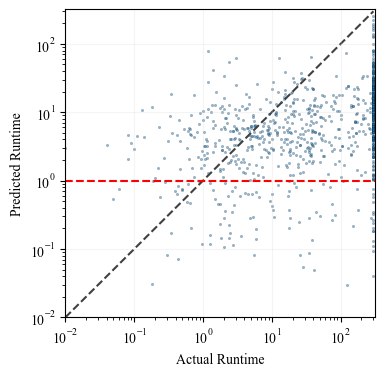

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    np.exp(y_test) - 1,
    np.exp(y_pred) - 1,
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.axhline(y=1, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
# plt.savefig("xgboost_aft.png", dpi=300, bbox_inches="tight")
plt.show()